In [1]:
colab = True

import os

if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 2')

Cloning into 'PUC_Redes_Neurais'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 321 (delta 124), reused 242 (delta 48), pack-reused 0
Receiving objects: 100% (321/321), 3.99 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (124/124), done.


# **PUC-Rio**
## **Departamento de Engenharia Elétrica**
## **Trabalho 2 - Previsão de séries temporais**

**Estudante:** Ana Arai

**Base de dados:** s_microclima3

## **OBSERVAÇÃO:**

Todas os resultados serão apresentados em texto com 3 rodadas, sendo este arquivo o da **terceira** rodada.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

from model_utils import train, train_multi_step_model

from tqdm.notebook import tqdm


## **Preparação para a lista**

In [3]:
class CustomDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


In [4]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar
  o mesmo modelo com apenas uma linha.

  Parâmetros de entrada:
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida.
  - hidden_activation: Função de ativação para cada camada escondida. Aceita
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]

    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h)
    y = self.fc2(h1)
    #y = self.out(h2)
    return y


In [5]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):

    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção.
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max


    data_values = data.values

    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)

    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)

    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')

    assert test_values.shape[0] >= (lag)

    _min = np.min(train_values)
    _max = np.max(train_values)

    if normalize:

        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)

    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))


    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))



    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]



    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]

    elif category == '1toN':
        pass

    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']


    new_data = np.hstack((t,new_data))

    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]


    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)]
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)




    return new_train_df, new_test_df





In [6]:
dataset_name = 'microclima3'
path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/s_{dataset_name}.csv'
raw_data = pd.read_csv(path)


## **Parte I - Compreensão do problema**

Total: 3,0 pts.

#### **1.1.	Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?**

In [7]:
raw_data

,value,time
0,39.277880,1.0
1,39.758673,2.0
2,37.317972,3.0
3,33.607143,4.0
4,27.605530,5.0
...,...,...
139,27.384332,8.0
140,30.956190,9.0
141,29.165438,10.0
142,37.649048,11.0


##### **1.1.1. Plotando o gráfico da série**

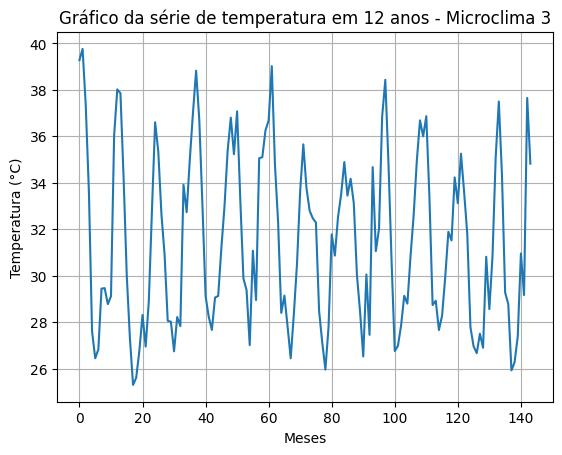

In [8]:
    plt.plot(raw_data.index, raw_data ['value'])
    plt.title ('Gráfico da série de temperatura em 12 anos - Microclima 3')
    plt.ylabel('Temperatura (°C)')
    plt.xlabel('Meses')
    plt.grid()

##### **1.1.2. Resposta**
Analisando o gráfico plotado, não é perceptível uma tendência nesta série, assim a série aparentemente é adequada para a modelagem usando Redes Neurais.
Caso não fosse adequada por apresentar uma tendência, deve-se utilizar técnicas para que a Rede Neural aprenda a tendência da série. Transformações como diferenciação ou outras técnicas de transformação dos dados podem ser aplicadas para estabilizar a variância ou torná-la mais estacionária.

Outra questão observada é que a série apresenta valores ruidosos, o que pode impactar num erro maior na previsão.

A inclusão de variáveis exógenas relevantes pode melhorar a previsão, principalmente se a tendência é influenciada por fatores externos, como, por exemplo, problemas de sazonalidade.

#### **1.2.	Nesta 2ª lista de exercícios, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?**

A variável exógena em um modelo de previsão de série temporal pode auxiliar na melhoria das previsões e na captura de relações mais complexas.

Ao incluir variáveis exógenas que têm uma relação significativa com a série temporal, o modelo pode capturar melhor as variações dos dados, assim fazendo previsões mais precisas. Pode ser aplicado em modelos quando há sazonalidade, tendências ou padrões complexos que não conseguem obter uma boa previsão apenas com os valores passados da série temporal.

#### **1.3. Observe que a base de dados não está em um formato adequado para o uso imediato de um modelo de Rede Neural para previsão de séries temporais. Descreva as etapas necessárias de transformação desta base de dados para que possamos utilizá-la no treinamento de uma MLP. Considere que os padrões de entrada (e saída) devem ser normalizados.**

**a) Definição da função 'transform_data'**

*   **'data'** é o conjunto de dados a ser adequado;Item da lista
*   **'lag'** é o tamanho de amostras na janela, sendo o valor padrão igual a 1;
*   **'test_split'** é a proporção de amostras para teste, o valor padrão 0,1 indica que 10% dos dados serão para teste;
*   **'normalize'** indica se os dados serão normalizados, valor padrão True indica que serão normalizados;

*   **'category'** especifica a codificação a ser realizada para a variável exógena (neste caso, o mês). O valor padrão é 'binary'.


    def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):

**b) Variáveis globais e manipulação dos dados de entrada'**

As variáveis globais são usadas para armazenar os valores de mínimo e máximo dos dados para a normalização.

Os dados de entrada são convertidos para um formato mais fácil de manipular.


    global _min
    global _max


    data_values = data.values

**c) Verifica a proporção dos dados de teste**

*Se a variável 'test_split' está entre 0 ou 1:*

*   1 é o número total de elementos nos dados;
*   Valores de treinamento é do início dos dados até a posição a última posição de treinamento (nº de dados * (1 - test_split);
*   Valores de teste é da última posição de treinamento até o último dado.



*Se a variável 'test_split' é maior que 1:*

*   Valores de treinamento é do início dos dados até a posição test_split;
*   Valores de teste é da posição test_split até o último dado.


*Se não:*


*   Imprime que não entendeu o 'Test split', que deveria ser um número real entre 0 ou 1 ou um inteiro para indexação.



*Verfica se o tamanho do conjunto de teste ('test_values') é pelo menos igual ao 'lag' especificado.*

*O 'lag' é um parâmetro que especifica quantos passos para trás devemos considerar ao criar amostras para previsão.*



    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)

    elif test_split > 1 and type(test_split) is int:
        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)

    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')

    assert test_values.shape[0] >= (lag)

**d) Normalização e preparação dos dados**

*   '_min' e '_max' calculam os valores mínimos e máximos dos dados de treinamento;
*   'if normalize:' normaliza os dados de treinamento e teste;
*   'train_data' e 'test_data' inicializam as matrizes para o armazenamento dos dados de treinamento e teste, com a quantidade de linhas igual ao de amostra e o número de colunas igual ao 'lag' mais 2 (uma coluna para a variável exógena e uma para cada 'lag');
*   'all_data' empilha os arrays de 'train_values' e 'test_values';
*   'all_idx' empilha os arrays dos índices dos valores de treinamento e teste,  'train_idx' e 'test_idx';
*   'new_data' cria uma matriz de zeros com a quantidade de linhas da a ser criada amostra de treinamento e teste, sendo o número de linhas o o total de amostras de treinamento menos o 'lag' mais 1. E o número de colunas sendo o 'lag' mais 2, adicionando uma coluna para a variável exógena e uma para a variável destino.



    _min = np.min(train_values)
    _max = np.max(train_values)

    if normalize:

        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)

    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))


    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))


**e) 'new_data' recebe os valores de 'all_data'**

Cada coluna de 'new_data' é preenchida com os valores de 'all_data', começando do índice 'i' até o final do conjunto de dados, considerando o 'lag'+ 1.

    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]

**f) Codificação da variável exógena**
*Se a variavél categórica for binária:*

*   A variável exógena será representada com 4 dígitos binários, de t0 a t3;
*   Cada dígito de cada representação é armazendo em uma coluna diferente de 't';

*   'temp_idx' contém os rótulos das colunas.



*Se a variavél categórica for '1toN':*

*   Não executa-se nada.



*Se a variável categórica não for binária e nem '1toN':*

*   Os índices 'all_idx' são normalizados e armazenado em 't'
*   O número de colunas de 'temp_idx' é 1, por ter apenas a variável 'month'.

    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]

    elif category == '1toN':
        pass

    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']

**g) Concatenação de 't' com 'new_data'**

A variável exógena codificada 't' é concantenada horizontalmente com a matriz 'new_data'.

    new_data = np.hstack((t,new_data))

**g) Separação dos dados completos de treinamento e teste**

    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]

**h) Criação e retorno dos DataFrames de treinamento e teste**


*   Cria rótulos de coluna para os DataFrames que serão criados. Os rótulos são baseados no 'lag' e indicam se as colunas representam o valor atual ('y(t)') ou valores anteriores ('y(t-i)' para 'i' variando de -'lag' a 1;
*   Adiciona os rótulos de coluna à lista 'temp_idx;
*   Cria os DataFrames de treinamento e teste;
*   Retorna os DataFrames de treinamento e teste.



    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)]
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)

    return new_train_df, new_test_df

## **Parte 2 - Previsão one-step**

Total: 2,0 pts

<b> IMPORTANTE! </b> Este processo não é a previsão multi-step, conforme ensinado em sala de aula.
Esta parte da lista é importante para evitar erros de avaliação para a previsão de séries temporais com um horizonte de previsão maior que 1.

#### **2.1.	Execute o script para a previsão one-step. Avalie o resultado (conjunto de treinamento e teste) usando métricas apropriadas, como RMSE e MAE.**

##### **2.1.1.	Rascunho**

In [9]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')

In [10]:
train_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.0,0.0,1.0,1.0,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.0,1.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.0,1.0,0.0,1.0,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.0,1.0,1.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,1.0,0.0,0.0,1.0,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,1.0,0.0,1.0,0.0,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,1.0,0.0,1.0,1.0,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [11]:
test_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,0.0,1.0,0.0,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,1.0,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,1.0,0.0,0.0,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,1.0,0.0,1.0,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,1.0,1.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,1.0,1.0,1.0,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,1.0,0.0,0.0,0.0,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,1.0,0.0,0.0,1.0,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,1.0,0.0,1.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [12]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [13]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [14]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [15]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [16]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  6%|▌         | 62/1000 [00:01<00:12, 72.60it/s]

Epoch 51/1000, Loss: 0.0302


 10%|█         | 103/1000 [00:01<00:11, 77.49it/s]

Epoch 101/1000, Loss: 0.0174


 16%|█▌        | 162/1000 [00:02<00:13, 63.47it/s]

Epoch 151/1000, Loss: 0.0126


 21%|██▏       | 213/1000 [00:03<00:09, 83.65it/s]

Epoch 201/1000, Loss: 0.0116


 26%|██▌       | 256/1000 [00:04<00:08, 86.91it/s]

Epoch 251/1000, Loss: 0.0114


 32%|███▏      | 319/1000 [00:04<00:05, 119.08it/s]

Epoch 301/1000, Loss: 0.0112


 37%|███▋      | 372/1000 [00:05<00:05, 120.51it/s]

Epoch 351/1000, Loss: 0.0110


 40%|████      | 401/1000 [00:05<00:05, 116.22it/s]

Epoch 401/1000, Loss: 0.0108


 46%|████▌     | 456/1000 [00:06<00:07, 72.96it/s]

Epoch 451/1000, Loss: 0.0107


 54%|█████▍    | 543/1000 [00:06<00:02, 179.71it/s]

Epoch 501/1000, Loss: 0.0105
Epoch 551/1000, Loss: 0.0104


 64%|██████▍   | 642/1000 [00:06<00:01, 224.51it/s]

Epoch 601/1000, Loss: 0.0102


 69%|██████▉   | 691/1000 [00:07<00:01, 233.56it/s]

Epoch 651/1000, Loss: 0.0101


 74%|███████▍  | 741/1000 [00:07<00:01, 240.39it/s]

Epoch 701/1000, Loss: 0.0100
Epoch 751/1000, Loss: 0.0099


 84%|████████▍ | 842/1000 [00:07<00:00, 243.61it/s]

Epoch 801/1000, Loss: 0.0098


 89%|████████▉ | 892/1000 [00:08<00:00, 241.63it/s]

Epoch 851/1000, Loss: 0.0098
Epoch 901/1000, Loss: 0.0097


100%|██████████| 1000/1000 [00:08<00:00, 118.40it/s]

Epoch 951/1000, Loss: 0.0096
Epoch 1001/1000, Loss: 0.0096


In [17]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()


Erro MSE = 6.511 
Erro MAE = 1.849


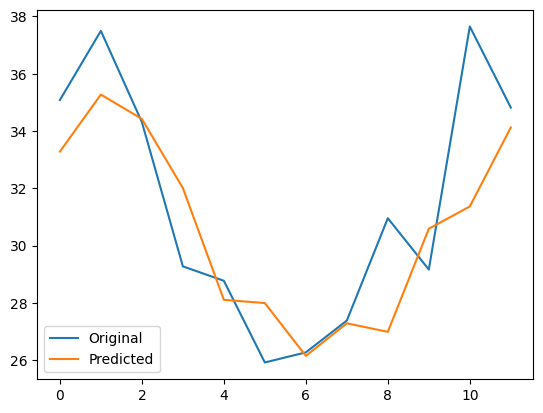

In [18]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')


In [19]:
media = raw_data ['value'].mean()
print (media)

31.477578080268074


In [20]:
erro_MAE_por_media = mae_error/media
print (erro_MAE_por_media)

0.058743393977924115


##### **2.1.2.	Resposta**

**Rodada 1:**

Erro MSE = **6.74** (°C)²

Erro MAE = **1.89** °C



**Rodada 2:**

Erro MSE = **6.78** (°C)²

Erro MAE = **1.89** °C



**Rodada 3:**

Erro MSE = **6.51** (°C)²

Erro MAE = **1.85** °C

O Mean Squared Error (MSE) mede a média dos quadrados das diferenças entre os valores reais e os valores previstos. Como eleva os erros ao quadrado, o MSE penaliza mais os grandes erros. Assim, sendo mais sensível a *outliers* por amplificar os grandes desvios. Já a unidade de saída do MSE dificulta a interpretação por ser elevado ao quadrado, nesse caso é (°C), não possuindo um significado físico. O MSE igual a **6,74** mostra que há grandes diferenças na previsão, como pode-se observar nos valores reais dos picos, da parte superior do gráfico, acima dos valores previstos. Desta forma, infere-se que a série apresenta valores ruidosos que impactam nos resultado da predição.

Já o Mean Absolute Error (MAE) mede a média das diferenças absolutas entre os valores reais e os valores previstos, sendo uma métrica direta da precisão do modelo, tendo a mesma unidade dos dados, facilitando a interpretação, nesse caso a unidade de MAE é °C, possuindo um significado físico. Por outro lado, comoarando com o MSE é menos sensível a *outliers*, pois não amplifica ao quadrado o erro. Nesta análise o erro MAE é de **1,89** °C, em percentual da média dos valores de temperaturas de toda série, é de **6,0%**. Dependendo do problema a ser aplicado a previsão desta série, pode ser um erro considerável. Este erro pode ser ocasionado pela série ruidosa.

#### **2.2.	Modifique a técnica de codificação mensal de ‘binário’ para ‘numérico’. Qual a mudança existente na arquitetura da Rede Neural? Analise o resultado (conjunto de treinamento e teste), usando as métricas adequadas.**

##### **2.2.1.	Rascunho**

In [21]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='numeric')



In [22]:
train_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.181818,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.272727,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.363636,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.454545,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.636364,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,0.727273,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,0.818182,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,0.909091,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [23]:
test_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.000000,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.090909,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.181818,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.272727,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.363636,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.454545,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.545455,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,0.636364,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,0.727273,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,0.818182,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [24]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [25]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [26]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [27]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [28]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

 10%|▉         | 98/1000 [00:00<00:03, 241.88it/s]

Epoch 51/1000, Loss: 0.0309


 15%|█▌        | 150/1000 [00:00<00:03, 248.74it/s]

Epoch 101/1000, Loss: 0.0188
Epoch 151/1000, Loss: 0.0149


 23%|██▎       | 227/1000 [00:00<00:03, 228.62it/s]

Epoch 201/1000, Loss: 0.0142


 28%|██▊       | 275/1000 [00:01<00:03, 231.73it/s]

Epoch 251/1000, Loss: 0.0140


 33%|███▎      | 326/1000 [00:01<00:02, 239.75it/s]

Epoch 301/1000, Loss: 0.0138
Epoch 351/1000, Loss: 0.0136


 43%|████▎     | 427/1000 [00:01<00:02, 245.47it/s]

Epoch 401/1000, Loss: 0.0135


 48%|████▊     | 477/1000 [00:01<00:02, 235.95it/s]

Epoch 451/1000, Loss: 0.0133


 53%|█████▎    | 528/1000 [00:02<00:01, 242.80it/s]

Epoch 501/1000, Loss: 0.0132
Epoch 551/1000, Loss: 0.0130


 63%|██████▎   | 634/1000 [00:02<00:01, 257.05it/s]

Epoch 601/1000, Loss: 0.0129
Epoch 651/1000, Loss: 0.0128


 74%|███████▎  | 736/1000 [00:03<00:01, 240.24it/s]

Epoch 701/1000, Loss: 0.0127


 79%|███████▊  | 786/1000 [00:03<00:00, 240.15it/s]

Epoch 751/1000, Loss: 0.0126


 84%|████████▎ | 837/1000 [00:03<00:00, 243.95it/s]

Epoch 801/1000, Loss: 0.0125
Epoch 851/1000, Loss: 0.0124


 93%|█████████▎| 932/1000 [00:03<00:00, 188.72it/s]

Epoch 901/1000, Loss: 0.0123


 97%|█████████▋| 971/1000 [00:04<00:00, 178.28it/s]

Epoch 951/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:04<00:00, 228.46it/s]

Epoch 1001/1000, Loss: 0.0122


In [29]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()


Erro MSE = 6.227 
Erro MAE = 1.826


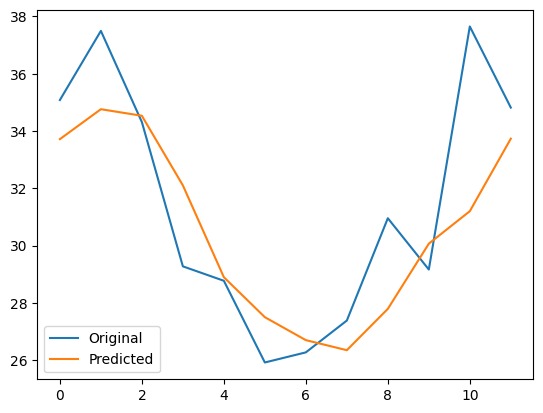

In [30]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')


##### **2.2.2.	Resposta**

Modificando a técnica de codificação mensal da variável exógena de 'binária' para 'numérica' os erros obtidos foram:


**Rodada 1:**

Erro MSE = **6.43** (°C)²

Erro MAE = **1.73** °C



**Rodada 2:**

Erro MSE = **6.08** (°C)²

Erro MAE = **1.79** °C



**Rodada 3:**

Erro MSE = **6.23** (°C)²

Erro MAE = **1.83** °C

Assim, nota-se que não há uma grande variação dos erros desta análise com a codificação da variável exógena 'numérica', em comparação com o item 2.1 com 'binária' apresenta erros MSE e MAE ligeiramente menor, então ambas as categorias para a variável exógena prevem séries de maneira similar. No caso binário, os meses foram codificadas pelas 4 variáveis, t0 a t3. Os resultados da análise numérica tiveram um desempenho um pouco melhor que a primeira, pois os meses podem ser modeladas como uma variável contínua, como pode se ver na variável 'month', cujo intervalo entre meses é de 0,0909.

Comparando os gráficos de valores reais e preditos para a codificação 'binária' e 'numérica', nota-se que na primeira o gráfico dos valores preditos ficou com mais "picos", já o da 'numérica' apresenta-se mais suave por ser representado com uma codificação de variável contínua.

## **Parte 3 - Previsão multi-step**

Total: 5,0 pts.

#### **3.1.	Esquematize como você implementaria o processo de previsão multi-step. Descreva todos os passos necessários, e em seguida compare com o código fornecido para a previsão.**

##### **3.1.1.	Rascunho**

In [31]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())

      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12

        #Alterando a variável mês
        X_t[0] = tmp/12

        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break


      X_t[-1] = y_hat

      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

##### **3.1.2.	Resposta**

###### **a) Definição da função e inicialização**

*   Define a função **'multi_step'** que recebe o modelo **'model'**, os dados de teste **'X_test'** e o tipo de codificação **'cod'**, sendo default 'numeric';
*   Inicializa uma lista, **'y_result'**, para armazenar as previsões;
*   Faz uma cópia da primeira amostra de **'X_test'** para iniciar a previsão.

    def multi_step(model, X_test, cod='numeric'):
      y_result = []
      X_t = np.copy(X_test[0])

###### **b) Previsão Multi-step**

*   Itera sobre o número de passos à frente;
*   Converte **'X_t'** para um tensor PyTorch e faz a previsão usando o modelo;

      for i in range(prev):
          y_hat = model(torch.from_numpy(X_t).float())

###### **c) Codificação numérica**
Se a codificação é **'numeric'**:
*   Calcula o valor do próximo mês **'tmp'**;
*   Normaliza o **'tmp'** para um intervalo entre 0 e 1;
*   Move todos os registros para uma posição a frente, deslizando a janela.

          if cod == 'numeric':

            #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e
            #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
            tmp = int(X_t[0] * 12 + 1) % 12

            #Alterando a variável mês
            X_t[0] = tmp/12

            #Movendo todos os registros, 'deslizando a janela'
            X_t[1:X_t.shape[0]-1] = X_t[2:]

###### **d) Codificação binária**

*   Não executa-se nada.

          elif cod == 'binary':
            pass

###### **e) Erro de codificação**
Se **'cod'** não é **'numeric'** e nem **'binary'**:
*   Imprime a mensagem de erro, **'Erro de codificação'**;
*   Interrompe o loop.


          else:
            print('Erro de codificação.')
            break

###### **f) Atualização e armazenamento**
*   Atualiza a entrada mais recente com a última previsão;
*   Armazena a última previsão na lista **'y_result'**.


          X_t[-1] = y_hat

          y_result.append(y_hat[0].detach().numpy())

###### **g) Retorno das previsões**
*   Retorna as previsões como um array.


      return np.array(y_result)

#### **3.2.	Faça a previsão multi-step para o horizonte de previsão igual a 12. Perceba que o resultado da métrica é, geralmente, pior do que o apresentado para a previsão one-step. Por quê? É justo comparar o resultado deste item com o que foi apresentado anteriormente? Discuta.**

##### **3.2.1.	Rascunho**

In [32]:
y_result = multi_step(model, X_test, cod='numeric')

Erro MSE = 8.564 
Erro MAE = 2.209


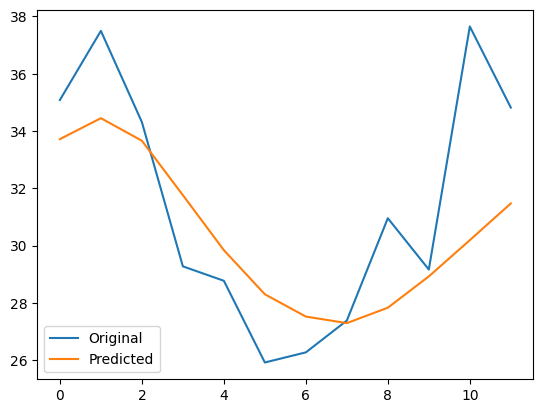

In [33]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### **3.2.2.	Resposta**

**RESULTADO DA ANÁLISE ONE-STEP**

**Rodada 1:**

Erro MSE = **6.43** (°C)²

Erro MAE = **1.73** °C

**Rodada 2:**

Erro MSE = **6.08** (°C)²

Erro MAE = **1.79** °C

**Rodada 3:**

Erro MSE = **6.23** (°C)²

Erro MAE = **1.83** °C

**RESULTADO DA ANÁLISE MULTI-STEP**

**Rodada 1:**

Erro MSE = **8.48** (°C)²

Erro MAE = **2.19** °C

**Rodada 2:**

Erro MSE = **8.52** (°C)²

Erro MAE = **2.20** °C

**Rodada 3:**

Erro MSE = **8.56** (°C)²

Erro MAE = **2.21** °C

O resultado da análise multi-step é pior, pois na análise one-step a previsão é feita apenas para o próximo passo, usando os dados mais recentes como entrada, assim limitando o acúmulo de erros. Já a multi-step faz previsões passos à frente e a previsão seguinte usa como entrada os valores previstos anteriormente, assim podendo acumular erros progressivamente.
Portanto, não é justo comparar os resultados da análise one-step com a multi-step, pela segunda apresentar os erros MSE e MAE mais elevados, devido à propagação dos erros.

#### **3.3.	Modifique o tamanho da janela de entrada do modelo. Analise os resultados, utilizando as métricas adequadas.**

##### **3.3.1.	Rascunho**

In [34]:
lag_list = [2,6,12,18,24,48,70]
mae_error_list = []
mse_error_list = []
n_output = 1
hidden_neurons = 20
lr = 0.05
epochs = 1000


for lag in lag_list:
    if lag > 12:
        prev = lag
    else:
        prev = 12
    train_val ,test_val = transform_data(raw_data,lag=lag,test_split = prev,normalize=True,category='numeric')

    print("\n \nTamanho da janela %i" %lag)
    print (train_val)
    print (test_val)

    train_values = train_val.values

    X_train = train_values[:,:-1]
    y_train = train_values[:,-1]

    test_values = test_val.values
    X_test = test_values[:,:-1]
    y_test = test_values[:,-1]

    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

    batch_size = 32

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    n_input = X_train.shape[1]

    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    history, y_hat = train(model, train_loader, epochs, device, lr)
    print("")

    y_result = multi_step(model, X_test, cod='numeric')

    orig_y_eval = y_test*(_max-_min) + _min
    orig_y_hat = y_result*(_max-_min) + _min

    mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
    mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

    # plt.plot(orig_y_eval)
    # plt.plot(orig_y_hat)
    # plt.legend(['Original','Predicted'])

    print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

    mae_error_list.append(round(mae_error, 2))
    mse_error_list.append(round(mse_error, 2))

# Resultado dos erros para o tamanho da janela
print("\n \nTamanho da janela", lag_list)
print("MSE erros:", mse_error_list)
print("MAE erros:", mae_error_list)


 
Tamanho da janela 2
        month    y(t-2)    y(t-1)      y(t)    y(t+1)
0    0.272727  0.966754  1.000000  0.831228  0.574628
1    0.363636  1.000000  0.831228  0.574628  0.159623
2    0.454545  0.831228  0.574628  0.159623  0.079324
3    0.545455  0.574628  0.159623  0.079324  0.105737
4    0.636364  0.159623  0.079324  0.105737  0.286608
..        ...       ...       ...       ...       ...
124  0.636364  0.171795  0.114689  0.094584  0.152517
125  0.727273  0.114689  0.094584  0.152517  0.110638
126  0.818182  0.094584  0.152517  0.110638  0.381441
127  0.909091  0.152517  0.110638  0.381441  0.225590
128  1.000000  0.110638  0.381441  0.225590  0.384723

[129 rows x 5 columns]
       month    y(t-2)    y(t-1)      y(t)    y(t+1)
0   0.000000  0.381441  0.225590  0.384723  0.676615
1   0.090909  0.225590  0.384723  0.676615  0.843498
2   0.181818  0.384723  0.676615  0.843498  0.623367
3   0.272727  0.676615  0.843498  0.623367  0.275147
4   0.363636  0.843498  0.623367  0.2751

  6%|▌         | 62/1000 [00:00<00:06, 142.21it/s]

Epoch 51/1000, Loss: 0.0002


 12%|█▏        | 120/1000 [00:00<00:06, 135.93it/s]

Epoch 101/1000, Loss: 0.0008


 18%|█▊        | 178/1000 [00:01<00:05, 140.69it/s]

Epoch 151/1000, Loss: 0.0011


 22%|██▏       | 223/1000 [00:01<00:05, 142.33it/s]

Epoch 201/1000, Loss: 0.0008


 27%|██▋       | 268/1000 [00:01<00:05, 141.94it/s]

Epoch 251/1000, Loss: 0.0004


 33%|███▎      | 329/1000 [00:02<00:04, 142.74it/s]

Epoch 301/1000, Loss: 0.0002


 37%|███▋      | 373/1000 [00:02<00:03, 178.55it/s]

Epoch 351/1000, Loss: 0.0000


 44%|████▎     | 435/1000 [00:02<00:02, 196.36it/s]

Epoch 401/1000, Loss: 0.0000


 48%|████▊     | 475/1000 [00:03<00:02, 194.41it/s]

Epoch 451/1000, Loss: 0.0000


 54%|█████▍    | 539/1000 [00:03<00:02, 205.72it/s]

Epoch 501/1000, Loss: 0.0000


 58%|█████▊    | 581/1000 [00:03<00:02, 203.90it/s]

Epoch 551/1000, Loss: 0.0000


 62%|██████▏   | 624/1000 [00:03<00:01, 204.91it/s]

Epoch 601/1000, Loss: 0.0000


 69%|██████▉   | 688/1000 [00:04<00:01, 200.05it/s]

Epoch 651/1000, Loss: 0.0000


 73%|███████▎  | 730/1000 [00:04<00:01, 199.32it/s]

Epoch 701/1000, Loss: 0.0000


 77%|███████▋  | 772/1000 [00:04<00:01, 202.42it/s]

Epoch 751/1000, Loss: 0.0000


 84%|████████▎ | 835/1000 [00:04<00:00, 201.55it/s]

Epoch 801/1000, Loss: 0.0000


 88%|████████▊ | 876/1000 [00:05<00:00, 188.44it/s]

Epoch 851/1000, Loss: 0.0000


 94%|█████████▍| 938/1000 [00:05<00:00, 197.70it/s]

Epoch 901/1000, Loss: 0.0000


 98%|█████████▊| 981/1000 [00:05<00:00, 200.02it/s]

Epoch 951/1000, Loss: 0.0000


100%|██████████| 1000/1000 [00:05<00:00, 175.86it/s]


Epoch 1001/1000, Loss: 0.0000

Erro MSE = 17.256 
Erro MAE = 3.707

 
Tamanho da janela 6
        month    y(t-6)    y(t-5)    y(t-4)    y(t-3)    y(t-2)    y(t-1)  \
0    0.636364  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1    0.727273  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2    0.818182  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3    0.909091  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4    1.000000  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
..        ...       ...       ...       ...       ...       ...       ...   
120  0.636364  0.540707  0.688145  0.573369  0.448349  0.171795  0.114689   
121  0.727273  0.688145  0.573369  0.448349  0.171795  0.114689  0.094584   
122  0.818182  0.573369  0.448349  0.171795  0.114689  0.094584  0.152517   
123  0.909091  0.448349  0.171795  0.114689  0.094584  0.152517  0.110638   
124  1.000000  0.171795  0.114689  0.094584  0.152517  0.110638

  8%|▊         | 75/1000 [00:00<00:03, 240.40it/s]

Epoch 51/1000, Loss: 0.0282


 12%|█▏        | 124/1000 [00:00<00:03, 227.21it/s]

Epoch 101/1000, Loss: 0.0199


 20%|██        | 200/1000 [00:00<00:03, 241.75it/s]

Epoch 151/1000, Loss: 0.0159
Epoch 201/1000, Loss: 0.0142


 28%|██▊       | 275/1000 [00:01<00:03, 239.21it/s]

Epoch 251/1000, Loss: 0.0135


 32%|███▏      | 324/1000 [00:01<00:02, 239.31it/s]

Epoch 301/1000, Loss: 0.0131


 40%|███▉      | 399/1000 [00:01<00:02, 239.22it/s]

Epoch 351/1000, Loss: 0.0128
Epoch 401/1000, Loss: 0.0126


 50%|█████     | 500/1000 [00:02<00:02, 247.15it/s]

Epoch 451/1000, Loss: 0.0124
Epoch 501/1000, Loss: 0.0122


 57%|█████▊    | 575/1000 [00:02<00:01, 247.03it/s]

Epoch 551/1000, Loss: 0.0121


 63%|██████▎   | 626/1000 [00:02<00:01, 241.84it/s]

Epoch 601/1000, Loss: 0.0119
Epoch 651/1000, Loss: 0.0118


 73%|███████▎  | 726/1000 [00:03<00:01, 240.52it/s]

Epoch 701/1000, Loss: 0.0117


 77%|███████▋  | 774/1000 [00:03<00:01, 218.44it/s]

Epoch 751/1000, Loss: 0.0115


 84%|████████▍ | 841/1000 [00:03<00:00, 214.24it/s]

Epoch 801/1000, Loss: 0.0114


 89%|████████▉ | 892/1000 [00:03<00:00, 232.10it/s]

Epoch 851/1000, Loss: 0.0113
Epoch 901/1000, Loss: 0.0112


 99%|█████████▉| 991/1000 [00:04<00:00, 238.34it/s]

Epoch 951/1000, Loss: 0.0112


100%|██████████| 1000/1000 [00:04<00:00, 235.52it/s]


Epoch 1001/1000, Loss: 0.0111

Erro MSE = 14.378 
Erro MAE = 3.107

 
Tamanho da janela 12
        month   y(t-12)   y(t-11)   y(t-10)    y(t-9)    y(t-8)    y(t-7)  \
0    0.090909  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1    0.181818  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2    0.272727  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3    0.363636  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4    0.454545  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
..        ...       ...       ...       ...       ...       ...       ...   
114  0.636364  0.163287  0.206051  0.320193  0.455912  0.430008  0.617567   
115  0.727273  0.206051  0.320193  0.455912  0.430008  0.617567  0.540707   
116  0.818182  0.320193  0.455912  0.430008  0.617567  0.540707  0.688145   
117  0.909091  0.455912  0.430008  0.617567  0.540707  0.688145  0.573369   
118  1.000000  0.430008  0.617567  0.540707  0.688145  0.57336

  8%|▊         | 75/1000 [00:00<00:03, 232.23it/s]

Epoch 51/1000, Loss: 0.0338
Epoch 101/1000, Loss: 0.0213


 18%|█▊        | 178/1000 [00:00<00:03, 247.92it/s]

Epoch 151/1000, Loss: 0.0152


 23%|██▎       | 229/1000 [00:00<00:03, 245.44it/s]

Epoch 201/1000, Loss: 0.0139
Epoch 251/1000, Loss: 0.0137


 33%|███▎      | 331/1000 [00:01<00:02, 243.59it/s]

Epoch 301/1000, Loss: 0.0136
Epoch 351/1000, Loss: 0.0135


 43%|████▎     | 433/1000 [00:01<00:02, 242.26it/s]

Epoch 401/1000, Loss: 0.0133


 48%|████▊     | 483/1000 [00:02<00:02, 239.17it/s]

Epoch 451/1000, Loss: 0.0132


 53%|█████▎    | 534/1000 [00:02<00:01, 244.75it/s]

Epoch 501/1000, Loss: 0.0130


 58%|█████▊    | 583/1000 [00:02<00:01, 210.86it/s]

Epoch 551/1000, Loss: 0.0129


 63%|██████▎   | 626/1000 [00:02<00:02, 183.36it/s]

Epoch 601/1000, Loss: 0.0127


 66%|██████▋   | 663/1000 [00:02<00:02, 163.25it/s]

Epoch 651/1000, Loss: 0.0126


 73%|███████▎  | 731/1000 [00:03<00:01, 159.23it/s]

Epoch 701/1000, Loss: 0.0125


 78%|███████▊  | 783/1000 [00:03<00:01, 161.57it/s]

Epoch 751/1000, Loss: 0.0124


 82%|████████▏ | 818/1000 [00:03<00:01, 163.83it/s]

Epoch 801/1000, Loss: 0.0123


 87%|████████▋ | 869/1000 [00:04<00:00, 162.63it/s]

Epoch 851/1000, Loss: 0.0122


 92%|█████████▏| 921/1000 [00:04<00:00, 162.96it/s]

Epoch 901/1000, Loss: 0.0121


 97%|█████████▋| 970/1000 [00:04<00:00, 157.28it/s]

Epoch 951/1000, Loss: 0.0120


100%|██████████| 1000/1000 [00:05<00:00, 194.66it/s]


Epoch 1001/1000, Loss: 0.0119

Erro MSE = 8.609 
Erro MAE = 2.204

 
Tamanho da janela 18
        month   y(t-18)   y(t-17)   y(t-16)   y(t-15)   y(t-14)   y(t-13)  \
0    0.636364  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1    0.727273  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2    0.818182  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3    0.909091  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4    1.000000  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
..        ...       ...       ...       ...       ...       ...       ...   
102  0.090909  0.176543  0.265194  0.241988  0.383226  0.506170  0.668011   
103  0.181818  0.265194  0.241988  0.383226  0.506170  0.668011  0.787349   
104  0.272727  0.241988  0.383226  0.506170  0.668011  0.787349  0.739774   
105  0.363636  0.383226  0.506170  0.668011  0.787349  0.739774  0.799904   
106  0.454545  0.506170  0.668011  0.787349  0.739774  0.799904

  8%|▊         | 80/1000 [00:00<00:04, 208.56it/s]

Epoch 51/1000, Loss: 0.0175


 13%|█▎        | 131/1000 [00:00<00:03, 231.37it/s]

Epoch 101/1000, Loss: 0.0100
Epoch 151/1000, Loss: 0.0092


 23%|██▎       | 233/1000 [00:01<00:03, 246.63it/s]

Epoch 201/1000, Loss: 0.0093
Epoch 251/1000, Loss: 0.0092


 34%|███▍      | 338/1000 [00:01<00:02, 250.37it/s]

Epoch 301/1000, Loss: 0.0091
Epoch 351/1000, Loss: 0.0089


 44%|████▎     | 436/1000 [00:01<00:02, 214.65it/s]

Epoch 401/1000, Loss: 0.0087


 48%|████▊     | 483/1000 [00:02<00:02, 221.06it/s]

Epoch 451/1000, Loss: 0.0085


 53%|█████▎    | 532/1000 [00:02<00:02, 230.22it/s]

Epoch 501/1000, Loss: 0.0084
Epoch 551/1000, Loss: 0.0082


 63%|██████▎   | 633/1000 [00:02<00:01, 244.80it/s]

Epoch 601/1000, Loss: 0.0081
Epoch 651/1000, Loss: 0.0080


 74%|███████▎  | 737/1000 [00:03<00:01, 256.36it/s]

Epoch 701/1000, Loss: 0.0078
Epoch 751/1000, Loss: 0.0077


 84%|████████▍ | 841/1000 [00:03<00:00, 246.81it/s]

Epoch 801/1000, Loss: 0.0076
Epoch 851/1000, Loss: 0.0075


 94%|█████████▍| 944/1000 [00:03<00:00, 249.08it/s]

Epoch 901/1000, Loss: 0.0074
Epoch 951/1000, Loss: 0.0073


100%|██████████| 1000/1000 [00:04<00:00, 237.41it/s]


Epoch 1001/1000, Loss: 0.0072

Erro MSE = 4.544 
Erro MAE = 1.739

 
Tamanho da janela 24
       month   y(t-24)   y(t-23)   y(t-22)   y(t-21)   y(t-20)   y(t-19)  \
0   0.090909  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1   0.181818  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2   0.272727  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3   0.363636  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4   0.454545  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
..       ...       ...       ...       ...       ...       ...       ...   
90  0.636364  0.084706  0.328639  0.149164  0.648286  0.398133  0.464260   
91  0.727273  0.328639  0.149164  0.648286  0.398133  0.464260  0.798757   
92  0.818182  0.149164  0.648286  0.398133  0.464260  0.798757  0.908060   
93  0.909091  0.648286  0.398133  0.464260  0.798757  0.908060  0.660522   
94  1.000000  0.398133  0.464260  0.798757  0.908060  0.660522  0.364876  

  8%|▊         | 85/1000 [00:00<00:03, 285.90it/s]

Epoch 51/1000, Loss: 0.0390
Epoch 101/1000, Loss: 0.0235


 22%|██▏       | 215/1000 [00:00<00:02, 315.24it/s]

Epoch 151/1000, Loss: 0.0163
Epoch 201/1000, Loss: 0.0142


 31%|███▏      | 314/1000 [00:01<00:02, 322.43it/s]

Epoch 251/1000, Loss: 0.0136
Epoch 301/1000, Loss: 0.0134


 41%|████      | 411/1000 [00:01<00:01, 309.86it/s]

Epoch 351/1000, Loss: 0.0132
Epoch 401/1000, Loss: 0.0131


 51%|█████     | 509/1000 [00:01<00:01, 318.20it/s]

Epoch 451/1000, Loss: 0.0129
Epoch 501/1000, Loss: 0.0128


 61%|██████    | 607/1000 [00:01<00:01, 320.44it/s]

Epoch 551/1000, Loss: 0.0127
Epoch 601/1000, Loss: 0.0126


 70%|███████   | 704/1000 [00:02<00:00, 308.36it/s]

Epoch 651/1000, Loss: 0.0125
Epoch 701/1000, Loss: 0.0123


 80%|████████  | 801/1000 [00:02<00:00, 293.80it/s]

Epoch 751/1000, Loss: 0.0122
Epoch 801/1000, Loss: 0.0121


 89%|████████▉ | 893/1000 [00:02<00:00, 297.16it/s]

Epoch 851/1000, Loss: 0.0120
Epoch 901/1000, Loss: 0.0120


100%|██████████| 1000/1000 [00:03<00:00, 302.77it/s]

Epoch 951/1000, Loss: 0.0119
Epoch 1001/1000, Loss: 0.0118

Erro MSE = 4.38 
Erro MAE = 1.674

 
Tamanho da janela 48
       month   y(t-48)   y(t-47)   y(t-46)   y(t-45)   y(t-44)   y(t-43)  \
0   0.090909  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1   0.181818  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2   0.272727  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   
3   0.363636  0.574628  0.159623  0.079324  0.105737  0.286608  0.288055   
4   0.454545  0.159623  0.079324  0.105737  0.286608  0.288055  0.240466   
5   0.545455  0.079324  0.105737  0.286608  0.288055  0.240466  0.263754   
6   0.636364  0.105737  0.286608  0.288055  0.240466  0.263754  0.742800   
7   0.727273  0.286608  0.288055  0.240466  0.263754  0.742800  0.879664   
8   0.818182  0.288055  0.240466  0.263754  0.742800  0.879664  0.868229   
9   0.909091  0.240466  0.263754  0.742800  0.879664  0.868229  0.617472   
10  1.000000  0.263754  0.742800  0.879664  0.


 12%|█▏        | 121/1000 [00:00<00:02, 401.01it/s]

Epoch 51/1000, Loss: 0.0201
Epoch 101/1000, Loss: 0.0137


 20%|██        | 205/1000 [00:00<00:01, 408.37it/s]

Epoch 151/1000, Loss: 0.0113
Epoch 201/1000, Loss: 0.0109


 34%|███▍      | 341/1000 [00:00<00:01, 441.15it/s]

Epoch 251/1000, Loss: 0.0109
Epoch 301/1000, Loss: 0.0109


 44%|████▎     | 435/1000 [00:01<00:01, 446.39it/s]

Epoch 351/1000, Loss: 0.0107
Epoch 401/1000, Loss: 0.0106


 53%|█████▎    | 533/1000 [00:01<00:01, 465.43it/s]

Epoch 451/1000, Loss: 0.0104
Epoch 501/1000, Loss: 0.0103


 64%|██████▎   | 635/1000 [00:01<00:00, 485.96it/s]

Epoch 551/1000, Loss: 0.0101
Epoch 601/1000, Loss: 0.0100
Epoch 651/1000, Loss: 0.0099


 79%|███████▉  | 788/1000 [00:01<00:00, 498.85it/s]

Epoch 701/1000, Loss: 0.0097
Epoch 751/1000, Loss: 0.0096
Epoch 801/1000, Loss: 0.0095


 89%|████████▉ | 888/1000 [00:01<00:00, 449.23it/s]

Epoch 851/1000, Loss: 0.0094
Epoch 901/1000, Loss: 0.0092


100%|██████████| 1000/1000 [00:02<00:00, 443.31it/s]


Epoch 951/1000, Loss: 0.0091
Epoch 1001/1000, Loss: 0.0090

Erro MSE = 4.832 
Erro MAE = 1.82

 
Tamanho da janela 70
      month   y(t-70)   y(t-69)   y(t-68)   y(t-67)   y(t-66)   y(t-65)  \
0  1.000000  0.966754  1.000000  0.831228  0.574628  0.159623  0.079324   
1  0.000000  1.000000  0.831228  0.574628  0.159623  0.079324  0.105737   
2  0.090909  0.831228  0.574628  0.159623  0.079324  0.105737  0.286608   

    y(t-64)   y(t-63)   y(t-62)  ...    y(t-8)    y(t-7)    y(t-6)    y(t-5)  \
0  0.105737  0.286608  0.288055  ...  0.655806  0.484636  0.214368  0.265894   
1  0.286608  0.288055  0.240466  ...  0.484636  0.214368  0.265894  0.174408   
2  0.288055  0.240466  0.263754  ...  0.214368  0.265894  0.174408  0.079384   

     y(t-4)    y(t-3)    y(t-2)    y(t-1)      y(t)    y(t+1)  
0  0.174408  0.079384  0.211662  0.361748  0.577131  0.716001  
1  0.079384  0.211662  0.361748  0.577131  0.716001  0.586084  
2  0.211662  0.361748  0.577131  0.716001  0.586084  0.518645  

[3 

 20%|█▉        | 196/1000 [00:00<00:00, 988.40it/s]

Epoch 51/1000, Loss: 0.0060
Epoch 101/1000, Loss: 0.0046
Epoch 151/1000, Loss: 0.0035
Epoch 201/1000, Loss: 0.0026
Epoch 251/1000, Loss: 0.0019


 41%|████      | 411/1000 [00:00<00:00, 906.10it/s] 

Epoch 301/1000, Loss: 0.0014
Epoch 351/1000, Loss: 0.0010
Epoch 401/1000, Loss: 0.0007
Epoch 451/1000, Loss: 0.0005


 59%|█████▉    | 589/1000 [00:00<00:00, 777.17it/s]

Epoch 501/1000, Loss: 0.0003
Epoch 551/1000, Loss: 0.0002
Epoch 601/1000, Loss: 0.0002


 75%|███████▌  | 750/1000 [00:00<00:00, 770.43it/s]

Epoch 651/1000, Loss: 0.0001
Epoch 701/1000, Loss: 0.0001
Epoch 751/1000, Loss: 0.0001
Epoch 801/1000, Loss: 0.0000


100%|██████████| 1000/1000 [00:01<00:00, 818.93it/s]

Epoch 851/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Epoch 951/1000, Loss: 0.0000
Epoch 1001/1000, Loss: 0.0000

Erro MSE = 19.929 
Erro MAE = 3.849

 
Tamanho da janela [2, 6, 12, 18, 24, 48, 70]
MSE erros: [17.26, 14.38, 8.61, 4.54, 4.38, 4.83, 19.93]
MAE erros: [3.71, 3.11, 2.2, 1.74, 1.67, 1.82, 3.85]


##### **3.3.2.	Resposta**

Nesta etapa o valor de prev foi definido maior que 12 para os casos onde o tamanho da janela é maior que 12, devido a limitação na função transform_data no seguinte trecho do código:
*assert test_values.shape[0] >= (lag)*

**Rodada 1:**

Tamanho da janela [2, 6, 12, 18, 24, 48, 70]

MSE erros: [16.76, 14.71, 8.73, 4.3, 4.28, 4.68, 21.41]

MAE erros: [3.68, 3.17, 2.23, 1.68, 1.62, 1.78, 3.98]

**Rodada 2:**

Tamanho da janela [2, 6, 12, 18, 24, 48, 70]

MSE erros: [17.05, 15.0, 9.03, 4.44, 4.41, 5.01, 20.72]

MAE erros: [3.69, 3.25, 2.23, 1.72, 1.67, 1.86, 3.87]

**Rodada 3:**

Tamanho da janela [2, 6, 12, 18, 24, 48, 70]

MSE erros: [17.26, 14.38, 8.61, 4.54, 4.38, 4.83, 19.93]

MAE erros: [3.71, 3.11, 2.2, 1.74, 1.67, 1.82, 3.85]

Os resultados obtidos mostram que para tamanho de janelas pequenos, como 2 e 6, os erros MSE e MAE são elevados, pois uma janela pequena não é capaz de prever adequadamente o comportamento anual da série. Por outro lado, um tamanho de janela extremamente grande, como o caso do 70, faz com que a amostra de treinamento fique extremamente reduzida, consequentemente não fazendo uma boa previsão.
Os melhores resultados obtidos nas métricas foram para janelas de tamanho 18, 24 e 48. Porém, este exercício propõe que seja feita a previsão de 12 meses a frente, como a função transform_data foi alterada, como explicado anteriormente, as análises com maior desempenho não estão de acordo com a proposta. Portanto, as próximas análises continurão utilizando um valor de 'prev' e 'lag' iguais a 12.

#### **3.4.	Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho.**

In [35]:
hidden_neurons_list = [1,2,5,10,15,20,30,40,50,100,200]

In [36]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='numeric')


In [37]:
train_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.181818,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.272727,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.363636,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.454545,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.636364,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,0.727273,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,0.818182,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,0.909091,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [38]:
test_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.000000,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.090909,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.181818,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.272727,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.363636,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.454545,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.545455,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,0.636364,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,0.727273,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,0.818182,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [39]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [40]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [41]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

##### **3.4.1.	Alterando número de processadores da camada escondida**

In [42]:
mae_error_list = []
mse_error_list = []
n_input = X_train.shape[1]
n_output = 1
lr = 0.05
epochs = 1000

for hidden_neurons in hidden_neurons_list:
    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\n \nHistorico do treinamento com %i" %hidden_neurons + " neuronios na camada escondida")
    history, y_hat = train(model, train_loader, epochs, device, lr)
    print("")

    y_result = multi_step(model, X_test, cod='numeric')

    orig_y_eval = y_test*(_max-_min) + _min
    orig_y_hat = y_result*(_max-_min) + _min

    mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
    mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

    # plt.plot(orig_y_eval)
    # plt.plot(orig_y_hat)
    # plt.legend(['Original','Predicted'])

    print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

    mae_error_list.append(round(mae_error, 2))
    mse_error_list.append(round(mse_error, 2))

# Resultado dos erros para o numero de neuronios na camada escondida
print("")
print("Numero de neuronios na camada escondida", hidden_neurons_list)
print("MSE erros:", mse_error_list)
print("MAE erros:", mae_error_list)



 
Historico do treinamento com 1 neuronios na camada escondida


  7%|▋         | 73/1000 [00:00<00:05, 176.23it/s]

Epoch 51/1000, Loss: 0.0311


 13%|█▎        | 129/1000 [00:00<00:05, 170.88it/s]

Epoch 101/1000, Loss: 0.0208


 18%|█▊        | 183/1000 [00:01<00:04, 168.95it/s]

Epoch 151/1000, Loss: 0.0154


 22%|██▏       | 217/1000 [00:01<00:04, 161.38it/s]

Epoch 201/1000, Loss: 0.0140


 27%|██▋       | 269/1000 [00:01<00:04, 163.70it/s]

Epoch 251/1000, Loss: 0.0138


 32%|███▏      | 319/1000 [00:01<00:04, 162.08it/s]

Epoch 301/1000, Loss: 0.0138


 38%|███▊      | 383/1000 [00:02<00:03, 196.32it/s]

Epoch 351/1000, Loss: 0.0137
Epoch 401/1000, Loss: 0.0137


 49%|████▊     | 486/1000 [00:02<00:02, 240.77it/s]

Epoch 451/1000, Loss: 0.0136
Epoch 501/1000, Loss: 0.0135


 59%|█████▊    | 587/1000 [00:03<00:01, 247.13it/s]

Epoch 551/1000, Loss: 0.0133
Epoch 601/1000, Loss: 0.0132


 69%|██████▉   | 691/1000 [00:03<00:01, 246.85it/s]

Epoch 651/1000, Loss: 0.0131


 74%|███████▍  | 742/1000 [00:03<00:01, 249.77it/s]

Epoch 701/1000, Loss: 0.0130
Epoch 751/1000, Loss: 0.0129


 85%|████████▍ | 846/1000 [00:04<00:00, 252.06it/s]

Epoch 801/1000, Loss: 0.0128
Epoch 851/1000, Loss: 0.0127


 92%|█████████▏| 924/1000 [00:04<00:00, 244.35it/s]

Epoch 901/1000, Loss: 0.0126


 98%|█████████▊| 975/1000 [00:04<00:00, 234.43it/s]

Epoch 951/1000, Loss: 0.0125


100%|██████████| 1000/1000 [00:04<00:00, 210.92it/s]


Epoch 1001/1000, Loss: 0.0124

Erro MSE = 8.059 
Erro MAE = 2.106

 
Historico do treinamento com 2 neuronios na camada escondida


  8%|▊         | 80/1000 [00:00<00:03, 254.70it/s]

Epoch 51/1000, Loss: 0.0432
Epoch 101/1000, Loss: 0.0367


 18%|█▊        | 183/1000 [00:00<00:03, 236.86it/s]

Epoch 151/1000, Loss: 0.0274


 23%|██▎       | 232/1000 [00:00<00:03, 240.92it/s]

Epoch 201/1000, Loss: 0.0197
Epoch 251/1000, Loss: 0.0163


 33%|███▎      | 334/1000 [00:01<00:02, 242.75it/s]

Epoch 301/1000, Loss: 0.0154
Epoch 351/1000, Loss: 0.0152


 44%|████▎     | 436/1000 [00:01<00:02, 240.96it/s]

Epoch 401/1000, Loss: 0.0151


 49%|████▉     | 488/1000 [00:01<00:02, 246.40it/s]

Epoch 451/1000, Loss: 0.0150
Epoch 501/1000, Loss: 0.0148


 59%|█████▊    | 587/1000 [00:02<00:01, 234.57it/s]

Epoch 551/1000, Loss: 0.0147


 64%|██████▎   | 637/1000 [00:02<00:01, 239.19it/s]

Epoch 601/1000, Loss: 0.0146
Epoch 651/1000, Loss: 0.0145


 74%|███████▎  | 737/1000 [00:03<00:01, 242.78it/s]

Epoch 701/1000, Loss: 0.0144


 79%|███████▊  | 787/1000 [00:03<00:00, 244.18it/s]

Epoch 751/1000, Loss: 0.0142
Epoch 801/1000, Loss: 0.0141


 89%|████████▊ | 887/1000 [00:03<00:00, 240.09it/s]

Epoch 851/1000, Loss: 0.0140


 94%|█████████▎| 936/1000 [00:03<00:00, 229.10it/s]

Epoch 901/1000, Loss: 0.0139


 98%|█████████▊| 984/1000 [00:04<00:00, 230.49it/s]

Epoch 951/1000, Loss: 0.0138


100%|██████████| 1000/1000 [00:04<00:00, 239.35it/s]


Epoch 1001/1000, Loss: 0.0137

Erro MSE = 7.773 
Erro MAE = 2.068

 
Historico do treinamento com 5 neuronios na camada escondida


  8%|▊         | 77/1000 [00:00<00:03, 248.92it/s]

Epoch 51/1000, Loss: 0.0331


 13%|█▎        | 127/1000 [00:00<00:03, 241.62it/s]

Epoch 101/1000, Loss: 0.0212


 18%|█▊        | 176/1000 [00:00<00:03, 225.01it/s]

Epoch 151/1000, Loss: 0.0147


 22%|██▎       | 225/1000 [00:00<00:03, 232.62it/s]

Epoch 201/1000, Loss: 0.0132


 28%|██▊       | 275/1000 [00:01<00:03, 236.50it/s]

Epoch 251/1000, Loss: 0.0131


 35%|███▍      | 348/1000 [00:01<00:02, 235.68it/s]

Epoch 301/1000, Loss: 0.0131


 37%|███▋      | 373/1000 [00:01<00:02, 237.86it/s]

Epoch 351/1000, Loss: 0.0130


 45%|████▍     | 449/1000 [00:01<00:02, 240.65it/s]

Epoch 401/1000, Loss: 0.0129
Epoch 451/1000, Loss: 0.0128


 55%|█████▌    | 550/1000 [00:02<00:01, 246.79it/s]

Epoch 501/1000, Loss: 0.0127
Epoch 551/1000, Loss: 0.0126


 63%|██████▎   | 627/1000 [00:02<00:01, 251.90it/s]

Epoch 601/1000, Loss: 0.0125


 68%|██████▊   | 679/1000 [00:02<00:01, 246.59it/s]

Epoch 651/1000, Loss: 0.0124
Epoch 701/1000, Loss: 0.0123


 76%|███████▌  | 756/1000 [00:03<00:00, 244.43it/s]

Epoch 751/1000, Loss: 0.0122


 82%|████████▏ | 821/1000 [00:03<00:01, 161.06it/s]

Epoch 801/1000, Loss: 0.0121


 88%|████████▊ | 876/1000 [00:03<00:00, 166.31it/s]

Epoch 851/1000, Loss: 0.0121


 93%|█████████▎| 930/1000 [00:04<00:00, 170.46it/s]

Epoch 901/1000, Loss: 0.0120


 98%|█████████▊| 985/1000 [00:04<00:00, 177.81it/s]

Epoch 951/1000, Loss: 0.0119


100%|██████████| 1000/1000 [00:04<00:00, 213.30it/s]


Epoch 1001/1000, Loss: 0.0119

Erro MSE = 7.882 
Erro MAE = 2.106

 
Historico do treinamento com 10 neuronios na camada escondida


  7%|▋         | 69/1000 [00:00<00:05, 166.60it/s]

Epoch 51/1000, Loss: 0.0259


 12%|█▏        | 120/1000 [00:00<00:05, 160.13it/s]

Epoch 101/1000, Loss: 0.0172


 17%|█▋        | 173/1000 [00:01<00:04, 165.40it/s]

Epoch 151/1000, Loss: 0.0145


 22%|██▏       | 223/1000 [00:01<00:04, 160.56it/s]

Epoch 201/1000, Loss: 0.0139


 27%|██▋       | 272/1000 [00:01<00:04, 150.39it/s]

Epoch 251/1000, Loss: 0.0136


 35%|███▍      | 348/1000 [00:02<00:03, 213.14it/s]

Epoch 301/1000, Loss: 0.0135
Epoch 351/1000, Loss: 0.0133


 45%|████▌     | 450/1000 [00:02<00:02, 242.39it/s]

Epoch 401/1000, Loss: 0.0131
Epoch 451/1000, Loss: 0.0129


 53%|█████▎    | 528/1000 [00:02<00:01, 249.79it/s]

Epoch 501/1000, Loss: 0.0128
Epoch 551/1000, Loss: 0.0127


 63%|██████▎   | 632/1000 [00:03<00:01, 253.98it/s]

Epoch 601/1000, Loss: 0.0125


 68%|██████▊   | 684/1000 [00:03<00:01, 249.17it/s]

Epoch 651/1000, Loss: 0.0124
Epoch 701/1000, Loss: 0.0123


 78%|███████▊  | 785/1000 [00:03<00:00, 245.66it/s]

Epoch 751/1000, Loss: 0.0122
Epoch 801/1000, Loss: 0.0121


 89%|████████▉ | 888/1000 [00:04<00:00, 248.99it/s]

Epoch 851/1000, Loss: 0.0120


 94%|█████████▍| 939/1000 [00:04<00:00, 243.67it/s]

Epoch 901/1000, Loss: 0.0119
Epoch 951/1000, Loss: 0.0118


100%|██████████| 1000/1000 [00:04<00:00, 214.00it/s]


Epoch 1001/1000, Loss: 0.0118

Erro MSE = 8.269 
Erro MAE = 2.157

 
Historico do treinamento com 15 neuronios na camada escondida


  8%|▊         | 77/1000 [00:00<00:03, 256.07it/s]

Epoch 51/1000, Loss: 0.0259
Epoch 101/1000, Loss: 0.0169


 18%|█▊        | 180/1000 [00:00<00:03, 245.25it/s]

Epoch 151/1000, Loss: 0.0146
Epoch 201/1000, Loss: 0.0142


 28%|██▊       | 282/1000 [00:01<00:02, 250.21it/s]

Epoch 251/1000, Loss: 0.0140


 39%|███▊      | 386/1000 [00:01<00:02, 251.28it/s]

Epoch 301/1000, Loss: 0.0139
Epoch 351/1000, Loss: 0.0137


 44%|████▎     | 437/1000 [00:01<00:02, 241.49it/s]

Epoch 401/1000, Loss: 0.0135


 49%|████▊     | 487/1000 [00:01<00:02, 242.16it/s]

Epoch 451/1000, Loss: 0.0134


 54%|█████▎    | 537/1000 [00:02<00:01, 243.00it/s]

Epoch 501/1000, Loss: 0.0132


 59%|█████▉    | 589/1000 [00:02<00:01, 248.29it/s]

Epoch 551/1000, Loss: 0.0131
Epoch 601/1000, Loss: 0.0129


 69%|██████▉   | 692/1000 [00:02<00:01, 237.83it/s]

Epoch 651/1000, Loss: 0.0128


 74%|███████▍  | 740/1000 [00:03<00:01, 236.18it/s]

Epoch 701/1000, Loss: 0.0127


 79%|███████▉  | 789/1000 [00:03<00:00, 240.24it/s]

Epoch 751/1000, Loss: 0.0126


 84%|████████▍ | 840/1000 [00:03<00:00, 244.28it/s]

Epoch 801/1000, Loss: 0.0125
Epoch 851/1000, Loss: 0.0124


 94%|█████████▍| 940/1000 [00:03<00:00, 236.87it/s]

Epoch 901/1000, Loss: 0.0123


100%|██████████| 1000/1000 [00:04<00:00, 243.75it/s]

Epoch 951/1000, Loss: 0.0122
Epoch 1001/1000, Loss: 0.0121



Erro MSE = 8.454 
Erro MAE = 2.196

 
Historico do treinamento com 20 neuronios na camada escondida


  8%|▊         | 78/1000 [00:00<00:03, 255.90it/s]

Epoch 51/1000, Loss: 0.0315
Epoch 101/1000, Loss: 0.0198


 18%|█▊        | 183/1000 [00:00<00:03, 246.38it/s]

Epoch 151/1000, Loss: 0.0146
Epoch 201/1000, Loss: 0.0134


 28%|██▊       | 284/1000 [00:01<00:02, 245.53it/s]

Epoch 251/1000, Loss: 0.0133


 34%|███▎      | 336/1000 [00:01<00:02, 249.31it/s]

Epoch 301/1000, Loss: 0.0133
Epoch 351/1000, Loss: 0.0133


 44%|████▎     | 437/1000 [00:01<00:02, 244.61it/s]

Epoch 401/1000, Loss: 0.0132
Epoch 451/1000, Loss: 0.0131


 54%|█████▍    | 538/1000 [00:02<00:01, 242.42it/s]

Epoch 501/1000, Loss: 0.0130


 59%|█████▉    | 588/1000 [00:02<00:01, 243.17it/s]

Epoch 551/1000, Loss: 0.0129


 64%|██████▍   | 640/1000 [00:02<00:01, 246.94it/s]

Epoch 601/1000, Loss: 0.0128


 69%|██████▉   | 689/1000 [00:02<00:01, 217.76it/s]

Epoch 651/1000, Loss: 0.0127


 71%|███████   | 712/1000 [00:03<00:01, 193.22it/s]

Epoch 701/1000, Loss: 0.0126


 77%|███████▋  | 769/1000 [00:03<00:01, 171.79it/s]

Epoch 751/1000, Loss: 0.0125


 82%|████████▏ | 823/1000 [00:03<00:01, 166.95it/s]

Epoch 801/1000, Loss: 0.0124


 88%|████████▊ | 879/1000 [00:04<00:00, 176.75it/s]

Epoch 851/1000, Loss: 0.0124


 94%|█████████▎| 935/1000 [00:04<00:00, 181.06it/s]

Epoch 901/1000, Loss: 0.0123


 97%|█████████▋| 973/1000 [00:04<00:00, 178.32it/s]

Epoch 951/1000, Loss: 0.0122


100%|██████████| 1000/1000 [00:04<00:00, 212.77it/s]


Epoch 1001/1000, Loss: 0.0122

Erro MSE = 8.603 
Erro MAE = 2.202

 
Historico do treinamento com 30 neuronios na camada escondida


  8%|▊         | 80/1000 [00:00<00:06, 152.85it/s]

Epoch 51/1000, Loss: 0.0271


 13%|█▎        | 131/1000 [00:00<00:05, 160.01it/s]

Epoch 101/1000, Loss: 0.0159


 18%|█▊        | 180/1000 [00:01<00:05, 149.93it/s]

Epoch 151/1000, Loss: 0.0129


 24%|██▍       | 240/1000 [00:01<00:04, 180.98it/s]

Epoch 201/1000, Loss: 0.0124


 29%|██▉       | 291/1000 [00:01<00:03, 216.54it/s]

Epoch 251/1000, Loss: 0.0123
Epoch 301/1000, Loss: 0.0122


 39%|███▉      | 390/1000 [00:02<00:02, 233.70it/s]

Epoch 351/1000, Loss: 0.0121


 44%|████▍     | 439/1000 [00:02<00:02, 237.51it/s]

Epoch 401/1000, Loss: 0.0120


 49%|████▉     | 488/1000 [00:02<00:02, 240.33it/s]

Epoch 451/1000, Loss: 0.0120


 54%|█████▍    | 538/1000 [00:02<00:01, 241.58it/s]

Epoch 501/1000, Loss: 0.0119


 59%|█████▉    | 588/1000 [00:02<00:01, 243.38it/s]

Epoch 551/1000, Loss: 0.0118


 64%|██████▍   | 638/1000 [00:03<00:01, 235.51it/s]

Epoch 601/1000, Loss: 0.0118


 69%|██████▉   | 688/1000 [00:03<00:01, 237.09it/s]

Epoch 651/1000, Loss: 0.0117


 74%|███████▍  | 739/1000 [00:03<00:01, 244.00it/s]

Epoch 701/1000, Loss: 0.0117
Epoch 751/1000, Loss: 0.0117


 84%|████████▍ | 839/1000 [00:03<00:00, 242.32it/s]

Epoch 801/1000, Loss: 0.0116


 89%|████████▉ | 890/1000 [00:04<00:00, 237.09it/s]

Epoch 851/1000, Loss: 0.0116


 94%|█████████▍| 941/1000 [00:04<00:00, 243.29it/s]

Epoch 901/1000, Loss: 0.0116
Epoch 951/1000, Loss: 0.0115


100%|██████████| 1000/1000 [00:04<00:00, 215.07it/s]


Epoch 1001/1000, Loss: 0.0115

Erro MSE = 9.448 
Erro MAE = 2.297

 
Historico do treinamento com 40 neuronios na camada escondida


 10%|▉         | 98/1000 [00:00<00:03, 240.51it/s]

Epoch 51/1000, Loss: 0.0209


 12%|█▏        | 123/1000 [00:00<00:03, 232.85it/s]

Epoch 101/1000, Loss: 0.0141


 20%|█▉        | 199/1000 [00:00<00:03, 243.63it/s]

Epoch 151/1000, Loss: 0.0133


 25%|██▍       | 249/1000 [00:01<00:03, 244.16it/s]

Epoch 201/1000, Loss: 0.0133


 30%|██▉       | 299/1000 [00:01<00:02, 243.59it/s]

Epoch 251/1000, Loss: 0.0133
Epoch 301/1000, Loss: 0.0133


 38%|███▊      | 375/1000 [00:01<00:02, 235.84it/s]

Epoch 351/1000, Loss: 0.0132


 45%|████▍     | 448/1000 [00:01<00:02, 238.60it/s]

Epoch 401/1000, Loss: 0.0131


 50%|████▉     | 497/1000 [00:02<00:02, 237.94it/s]

Epoch 451/1000, Loss: 0.0130


 55%|█████▍    | 546/1000 [00:02<00:01, 231.19it/s]

Epoch 501/1000, Loss: 0.0130


 60%|█████▉    | 595/1000 [00:02<00:01, 236.87it/s]

Epoch 551/1000, Loss: 0.0129


 64%|██████▍   | 644/1000 [00:02<00:01, 233.21it/s]

Epoch 601/1000, Loss: 0.0128


 69%|██████▉   | 692/1000 [00:02<00:01, 227.83it/s]

Epoch 651/1000, Loss: 0.0128


 74%|███████▍  | 742/1000 [00:03<00:01, 236.44it/s]

Epoch 701/1000, Loss: 0.0127
Epoch 751/1000, Loss: 0.0126


 84%|████████▍ | 841/1000 [00:03<00:00, 240.77it/s]

Epoch 801/1000, Loss: 0.0126


 89%|████████▉ | 889/1000 [00:03<00:00, 217.88it/s]

Epoch 851/1000, Loss: 0.0125


 94%|█████████▎| 936/1000 [00:03<00:00, 225.89it/s]

Epoch 901/1000, Loss: 0.0125


 98%|█████████▊| 983/1000 [00:04<00:00, 227.58it/s]

Epoch 951/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:04<00:00, 234.06it/s]


Epoch 1001/1000, Loss: 0.0124

Erro MSE = 9.417 
Erro MAE = 2.312

 
Historico do treinamento com 50 neuronios na camada escondida


  8%|▊         | 75/1000 [00:00<00:03, 238.90it/s]

Epoch 51/1000, Loss: 0.0196


 15%|█▌        | 150/1000 [00:00<00:03, 238.95it/s]

Epoch 101/1000, Loss: 0.0142
Epoch 151/1000, Loss: 0.0138


 23%|██▎       | 226/1000 [00:00<00:03, 244.12it/s]

Epoch 201/1000, Loss: 0.0138


 28%|██▊       | 276/1000 [00:01<00:03, 241.17it/s]

Epoch 251/1000, Loss: 0.0137


 32%|███▎      | 325/1000 [00:01<00:02, 238.48it/s]

Epoch 301/1000, Loss: 0.0135


 40%|███▉      | 397/1000 [00:01<00:02, 232.84it/s]

Epoch 351/1000, Loss: 0.0134


 45%|████▍     | 446/1000 [00:01<00:02, 235.64it/s]

Epoch 401/1000, Loss: 0.0133


 49%|████▉     | 494/1000 [00:02<00:02, 233.07it/s]

Epoch 451/1000, Loss: 0.0132


 54%|█████▍    | 543/1000 [00:02<00:01, 233.23it/s]

Epoch 501/1000, Loss: 0.0131


 57%|█████▋    | 567/1000 [00:02<00:01, 230.63it/s]

Epoch 551/1000, Loss: 0.0130


 63%|██████▎   | 632/1000 [00:02<00:02, 180.09it/s]

Epoch 601/1000, Loss: 0.0129


 67%|██████▋   | 669/1000 [00:03<00:01, 170.19it/s]

Epoch 651/1000, Loss: 0.0128


 72%|███████▏  | 721/1000 [00:03<00:01, 164.47it/s]

Epoch 701/1000, Loss: 0.0128


 77%|███████▋  | 774/1000 [00:03<00:01, 169.00it/s]

Epoch 751/1000, Loss: 0.0127


 83%|████████▎ | 829/1000 [00:04<00:00, 172.55it/s]

Epoch 801/1000, Loss: 0.0126


 88%|████████▊ | 881/1000 [00:04<00:00, 159.88it/s]

Epoch 851/1000, Loss: 0.0126


 93%|█████████▎| 930/1000 [00:04<00:00, 153.48it/s]

Epoch 901/1000, Loss: 0.0125


 98%|█████████▊| 979/1000 [00:04<00:00, 155.88it/s]

Epoch 951/1000, Loss: 0.0124


100%|██████████| 1000/1000 [00:05<00:00, 194.31it/s]


Epoch 1001/1000, Loss: 0.0124

Erro MSE = 9.509 
Erro MAE = 2.301

 
Historico do treinamento com 100 neuronios na camada escondida


  7%|▋         | 67/1000 [00:00<00:06, 153.68it/s]

Epoch 51/1000, Loss: 0.0204


 14%|█▍        | 144/1000 [00:00<00:04, 189.99it/s]

Epoch 101/1000, Loss: 0.0140


 19%|█▉        | 193/1000 [00:01<00:03, 217.15it/s]

Epoch 151/1000, Loss: 0.0131


 24%|██▍       | 241/1000 [00:01<00:03, 228.29it/s]

Epoch 201/1000, Loss: 0.0129


 29%|██▊       | 287/1000 [00:01<00:03, 226.40it/s]

Epoch 251/1000, Loss: 0.0128


 34%|███▎      | 335/1000 [00:01<00:02, 225.30it/s]

Epoch 301/1000, Loss: 0.0127


 38%|███▊      | 384/1000 [00:01<00:02, 232.42it/s]

Epoch 351/1000, Loss: 0.0126


 43%|████▎     | 434/1000 [00:02<00:02, 239.48it/s]

Epoch 401/1000, Loss: 0.0125


 48%|████▊     | 483/1000 [00:02<00:02, 238.37it/s]

Epoch 451/1000, Loss: 0.0124


 53%|█████▎    | 531/1000 [00:02<00:02, 233.43it/s]

Epoch 501/1000, Loss: 0.0123


 58%|█████▊    | 580/1000 [00:02<00:01, 233.72it/s]

Epoch 551/1000, Loss: 0.0122


 63%|██████▎   | 628/1000 [00:02<00:01, 235.06it/s]

Epoch 601/1000, Loss: 0.0121


 68%|██████▊   | 676/1000 [00:03<00:01, 235.37it/s]

Epoch 651/1000, Loss: 0.0120


 72%|███████▎  | 725/1000 [00:03<00:01, 238.36it/s]

Epoch 701/1000, Loss: 0.0120


 78%|███████▊  | 775/1000 [00:03<00:00, 234.30it/s]

Epoch 751/1000, Loss: 0.0119


 83%|████████▎ | 826/1000 [00:03<00:00, 242.40it/s]

Epoch 801/1000, Loss: 0.0118


 88%|████████▊ | 877/1000 [00:03<00:00, 241.15it/s]

Epoch 851/1000, Loss: 0.0118


 93%|█████████▎| 928/1000 [00:04<00:00, 242.16it/s]

Epoch 901/1000, Loss: 0.0117
Epoch 951/1000, Loss: 0.0117


100%|██████████| 1000/1000 [00:04<00:00, 223.55it/s]


Epoch 1001/1000, Loss: 0.0117

Erro MSE = 9.636 
Erro MAE = 2.302

 
Historico do treinamento com 200 neuronios na camada escondida


 10%|▉         | 95/1000 [00:00<00:03, 237.18it/s]

Epoch 51/1000, Loss: 0.0648


 14%|█▍        | 143/1000 [00:00<00:03, 236.60it/s]

Epoch 101/1000, Loss: 0.0638


 19%|█▉        | 191/1000 [00:00<00:03, 236.86it/s]

Epoch 151/1000, Loss: 0.0629


 24%|██▍       | 242/1000 [00:01<00:03, 244.47it/s]

Epoch 201/1000, Loss: 0.0620
Epoch 251/1000, Loss: 0.0613


 34%|███▍      | 341/1000 [00:01<00:02, 235.94it/s]

Epoch 301/1000, Loss: 0.0606


 39%|███▉      | 389/1000 [00:01<00:02, 235.53it/s]

Epoch 351/1000, Loss: 0.0599


 44%|████▎     | 436/1000 [00:01<00:02, 214.49it/s]

Epoch 401/1000, Loss: 0.0593


 48%|████▊     | 483/1000 [00:02<00:02, 221.62it/s]

Epoch 451/1000, Loss: 0.0588


 53%|█████▎    | 530/1000 [00:02<00:02, 225.78it/s]

Epoch 501/1000, Loss: 0.0583


 58%|█████▊    | 577/1000 [00:02<00:01, 229.23it/s]

Epoch 551/1000, Loss: 0.0578


 62%|██████▏   | 624/1000 [00:02<00:01, 230.00it/s]

Epoch 601/1000, Loss: 0.0573


 70%|██████▉   | 697/1000 [00:03<00:01, 235.86it/s]

Epoch 651/1000, Loss: 0.0569


 74%|███████▍  | 744/1000 [00:03<00:01, 226.35it/s]

Epoch 701/1000, Loss: 0.0565


 79%|███████▉  | 792/1000 [00:03<00:00, 230.24it/s]

Epoch 751/1000, Loss: 0.0561


 84%|████████▍ | 840/1000 [00:03<00:00, 229.70it/s]

Epoch 801/1000, Loss: 0.0557


 89%|████████▉ | 889/1000 [00:03<00:00, 232.85it/s]

Epoch 851/1000, Loss: 0.0554


 94%|█████████▎| 937/1000 [00:04<00:00, 235.34it/s]

Epoch 901/1000, Loss: 0.0550


 99%|█████████▊| 986/1000 [00:04<00:00, 229.30it/s]

Epoch 951/1000, Loss: 0.0547


100%|██████████| 1000/1000 [00:04<00:00, 229.99it/s]

Epoch 1001/1000, Loss: 0.0544

Erro MSE = 19.787 
Erro MAE = 3.664

Numero de neuronios na camada escondida [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]
MSE erros: [8.06, 7.77, 7.88, 8.27, 8.45, 8.6, 9.45, 9.42, 9.51, 9.64, 19.79]
MAE erros: [2.11, 2.07, 2.11, 2.16, 2.2, 2.2, 2.3, 2.31, 2.3, 2.3, 3.66]


##### **3.4.2.	Alterando o tipo de função na camada de saída**

In [43]:
hidden_activation_list = ['sigmoid','relu','softmax']
hidden_neurons = 10
mae_error_list = []
mse_error_list = []
n_input = X_train.shape[1]
n_output = 1
lr = 0.05
epochs = 1000

for hidden_activation in hidden_activation_list:
    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation=hidden_activation)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\n \nTipo de função ", hidden_activation)
    history, y_hat = train(model, train_loader, epochs, device, lr)
    print("")

    y_result = multi_step(model, X_test, cod='numeric')

    orig_y_eval = y_test*(_max-_min) + _min
    orig_y_hat = y_result*(_max-_min) + _min

    mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
    mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

    # plt.plot(orig_y_eval)
    # plt.plot(orig_y_hat)
    # plt.legend(['Original','Predicted'])

    print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

    mae_error_list.append(round(mae_error, 2))
    mse_error_list.append(round(mse_error, 2))

# Resultado dos erros para os tipos de função de ativação
print("")
print("Tipo de funcao", hidden_activation_list)
print("MSE erros:", mse_error_list)
print("MAE erros:", mae_error_list)



 
Tipo de função  sigmoid


  8%|▊         | 76/1000 [00:00<00:03, 251.68it/s]

Epoch 51/1000, Loss: 0.0274
Epoch 101/1000, Loss: 0.0176


 18%|█▊        | 178/1000 [00:00<00:03, 241.55it/s]

Epoch 151/1000, Loss: 0.0141


 23%|██▎       | 227/1000 [00:00<00:03, 235.19it/s]

Epoch 201/1000, Loss: 0.0135


 28%|██▊       | 278/1000 [00:01<00:02, 242.43it/s]

Epoch 251/1000, Loss: 0.0135
Epoch 301/1000, Loss: 0.0135


 38%|███▊      | 382/1000 [00:01<00:02, 251.67it/s]

Epoch 351/1000, Loss: 0.0134
Epoch 401/1000, Loss: 0.0133


 46%|████▌     | 461/1000 [00:01<00:02, 230.56it/s]

Epoch 451/1000, Loss: 0.0131


 53%|█████▎    | 528/1000 [00:02<00:02, 189.23it/s]

Epoch 501/1000, Loss: 0.0130


 58%|█████▊    | 585/1000 [00:02<00:02, 177.26it/s]

Epoch 551/1000, Loss: 0.0129


 62%|██████▏   | 621/1000 [00:02<00:02, 173.63it/s]

Epoch 601/1000, Loss: 0.0128


 68%|██████▊   | 676/1000 [00:03<00:01, 175.90it/s]

Epoch 651/1000, Loss: 0.0126


 73%|███████▎  | 733/1000 [00:03<00:01, 178.83it/s]

Epoch 701/1000, Loss: 0.0125


 77%|███████▋  | 769/1000 [00:03<00:01, 175.27it/s]

Epoch 751/1000, Loss: 0.0124


 82%|████████▏ | 823/1000 [00:04<00:01, 160.12it/s]

Epoch 801/1000, Loss: 0.0123


 87%|████████▋ | 873/1000 [00:04<00:00, 158.93it/s]

Epoch 851/1000, Loss: 0.0122


 89%|████████▉ | 889/1000 [00:04<00:00, 156.53it/s]

Epoch 901/1000, Loss: 0.0122


100%|██████████| 1000/1000 [00:05<00:00, 172.15it/s]

Epoch 951/1000, Loss: 0.0121
Epoch 1001/1000, Loss: 0.0120



Erro MSE = 8.142 
Erro MAE = 2.193

 
Tipo de função  relu


  8%|▊         | 75/1000 [00:00<00:03, 237.11it/s]

Epoch 51/1000, Loss: 0.0142


 13%|█▎        | 126/1000 [00:00<00:03, 246.37it/s]

Epoch 101/1000, Loss: 0.0131
Epoch 151/1000, Loss: 0.0123


 23%|██▎       | 230/1000 [00:00<00:03, 249.77it/s]

Epoch 201/1000, Loss: 0.0116
Epoch 251/1000, Loss: 0.0109


 33%|███▎      | 332/1000 [00:01<00:02, 239.69it/s]

Epoch 301/1000, Loss: 0.0103


 38%|███▊      | 382/1000 [00:01<00:02, 243.36it/s]

Epoch 351/1000, Loss: 0.0100
Epoch 401/1000, Loss: 0.0098


 48%|████▊     | 484/1000 [00:01<00:02, 249.33it/s]

Epoch 451/1000, Loss: 0.0097


 53%|█████▎    | 533/1000 [00:02<00:02, 230.91it/s]

Epoch 501/1000, Loss: 0.0095


 58%|█████▊    | 581/1000 [00:02<00:01, 231.45it/s]

Epoch 551/1000, Loss: 0.0094


 63%|██████▎   | 630/1000 [00:02<00:01, 234.34it/s]

Epoch 601/1000, Loss: 0.0093


 68%|██████▊   | 681/1000 [00:02<00:01, 243.52it/s]

Epoch 651/1000, Loss: 0.0092
Epoch 701/1000, Loss: 0.0092


 78%|███████▊  | 782/1000 [00:03<00:00, 237.23it/s]

Epoch 751/1000, Loss: 0.0091


 83%|████████▎ | 833/1000 [00:03<00:00, 240.97it/s]

Epoch 801/1000, Loss: 0.0090
Epoch 851/1000, Loss: 0.0089


 94%|█████████▎| 935/1000 [00:03<00:00, 247.33it/s]

Epoch 901/1000, Loss: 0.0089


 99%|█████████▊| 986/1000 [00:04<00:00, 246.32it/s]

Epoch 951/1000, Loss: 0.0089


100%|██████████| 1000/1000 [00:04<00:00, 240.78it/s]


Epoch 1001/1000, Loss: 0.0088

Erro MSE = 8.963 
Erro MAE = 2.156

 
Tipo de função  softmax


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 10%|▉         | 96/1000 [00:00<00:03, 233.01it/s]

Epoch 51/1000, Loss: 0.0441


 14%|█▍        | 145/1000 [00:00<00:03, 238.27it/s]

Epoch 101/1000, Loss: 0.0404


 20%|█▉        | 195/1000 [00:00<00:03, 239.03it/s]

Epoch 151/1000, Loss: 0.0361


 24%|██▍       | 245/1000 [00:01<00:03, 242.12it/s]

Epoch 201/1000, Loss: 0.0307


 29%|██▉       | 294/1000 [00:01<00:03, 234.82it/s]

Epoch 251/1000, Loss: 0.0247


 34%|███▍      | 342/1000 [00:01<00:02, 222.79it/s]

Epoch 301/1000, Loss: 0.0194


 39%|███▉      | 391/1000 [00:01<00:02, 230.66it/s]

Epoch 351/1000, Loss: 0.0165


 44%|████▍     | 440/1000 [00:01<00:02, 232.43it/s]

Epoch 401/1000, Loss: 0.0156


 49%|████▉     | 490/1000 [00:02<00:02, 238.01it/s]

Epoch 451/1000, Loss: 0.0154
Epoch 501/1000, Loss: 0.0153


 59%|█████▉    | 588/1000 [00:02<00:01, 238.33it/s]

Epoch 551/1000, Loss: 0.0153


 64%|██████▎   | 637/1000 [00:02<00:01, 240.88it/s]

Epoch 601/1000, Loss: 0.0151


 69%|██████▉   | 688/1000 [00:02<00:01, 243.24it/s]

Epoch 651/1000, Loss: 0.0150


 74%|███████▍  | 738/1000 [00:03<00:01, 241.94it/s]

Epoch 701/1000, Loss: 0.0148


 79%|███████▉  | 788/1000 [00:03<00:00, 234.82it/s]

Epoch 751/1000, Loss: 0.0147


 84%|████████▎ | 836/1000 [00:03<00:00, 233.90it/s]

Epoch 801/1000, Loss: 0.0145


 88%|████████▊ | 884/1000 [00:03<00:00, 235.74it/s]

Epoch 851/1000, Loss: 0.0144


 93%|█████████▎| 932/1000 [00:03<00:00, 235.45it/s]

Epoch 901/1000, Loss: 0.0143


 96%|█████████▌| 956/1000 [00:04<00:00, 232.24it/s]

Epoch 951/1000, Loss: 0.0141


100%|██████████| 1000/1000 [00:04<00:00, 210.93it/s]

Epoch 1001/1000, Loss: 0.0140

Erro MSE = 8.323 
Erro MAE = 2.192

Tipo de funcao ['sigmoid', 'relu', 'softmax']
MSE erros: [8.14, 8.96, 8.32]
MAE erros: [2.19, 2.16, 2.19]


##### **3.4.3.	Resposta**

**ALTERANDO O NÚMERO DE NEURÔNIOS NA CAMADA ESCONDIDA**

**Rodada 1:**

Numero de neurônios na camada escondida [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]

MSE erros: [7.7, 8.01, 7.6, 8.4, 8.75, 8.52, 8.66, 9.18, 9.88, 9.76, 26.67]

MAE erros: [2.05, 2.11, 2.06, 2.18, 2.25, 2.21, 2.23, 2.28, 2.33, 2.34, 4.06]

**Rodada 2:**

Numero de neurônios na camada escondida [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]

MSE erros: [8.3, 7.84, 8.36, 8.43, 8.38, 8.56, 9.23, 9.8, 9.76, 9.68, 20.02]

MAE erros: [2.17, 2.08, 2.18, 2.18, 2.17, 2.17, 2.25, 2.34, 2.34, 2.32, 3.72]

**Rodada 3:**

Numero de neurônios na camada escondida [1, 2, 5, 10, 15, 20, 30, 40, 50, 100, 200]

MSE erros: [8.06, 7.77, 7.88, 8.27, 8.45, 8.6, 9.45, 9.42, 9.51, 9.64, 19.79]

MAE erros: [2.11, 2.07, 2.11, 2.16, 2.2, 2.2, 2.3, 2.31, 2.3, 2.3, 3.66]

Variando o número de neurônios na camada escondida os valores variaram pouco, com exceção da última análise com 200 neurônios. Apresentaram melhores resultados para a quantidade de 1, 2, 5 e 10 neurônios na camada escondida. Os valores de MAE apresentaram pouca variação de 1 a 100 neurônios, mas de MSE para o intervalo de 30 a 100 neurônios teve um aumento de aproximadamente 1 quando comparados com o de 20 neurônios.
Os resultados obtidos na análise com 200 neurônios estão os valores de erros muito elevados, por causa do número elevado de neurônios na camada escondida, assim causando o problema de *overfitting*.


**ALTERANDO A FUNÇÃO DE ATIVAÇÃO**

**Rodada 1:**

Tipo de função: ['sigmoid', 'relu', 'softmax']

MSE erros: [8.29, 10.18, 8.12]

MAE erros: [2.16, 2.43, 2.22]

**Rodada 2:**

Tipo de função: ['sigmoid', 'relu', 'softmax']

MSE erros: [8.19, 9.82, 8.65]

MAE erros: [2.19, 2.33, 2.23]


**Rodada 3:**

Tipo de função: ['sigmoid', 'relu', 'softmax']

MSE erros: [8.14, 8.96, 8.32]

MAE erros: [2.19, 2.16, 2.19]

Alterando a função de ativação da camada de saída de 'sigmoid' para 'relu' e 'softmax' os valores de erro MAE apresentaram valores próximos. Já para erro MSE os valores para as funções 'sigmoid' e 'softmax' são quase os mesmos, porém a 'relu'apresentou erro MSE maior, apresentando grandes desvios na previsão.

#### **3.5. Modifique a função de previsão multi-step para permitir a codificação binária da variável mês. Em seguida, treine um modelo MLP usando a codificação binária para a variável exógena e faça a previsão multi-step e analise o resultado.**

OBS: Para este item, basta alterar a atualização da variável exógena na condição desejada (no caso, cod = 'binary')

##### **3.5.1.	Rascunho**

In [44]:
def new_multi_step(model, X_test, cod='binary'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())

      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12

        #Alterando a variável mês
        X_t[0] = tmp/12

        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        tmp_binary = int(X_t[0] * 12 + 1) % 12

        # De fevereiro a julho X_t[0] = 1
        if tmp_binary in [1, 2, 3, 4, 5, 6]:
            X_t[0] = 1

        else:
            X_t[0] = 0

        # Deslizando a janela
        X_t[1:X_t.shape[0]-1] = X_t[2:]
      else:
        print('Erro de codificação.')
        break


      X_t[-1] = y_hat

      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

In [45]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')


In [46]:
train_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.966754,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229
1,0.0,0.0,1.0,1.0,1.000000,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472
2,0.0,1.0,0.0,0.0,0.831228,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416
3,0.0,1.0,0.0,1.0,0.574628,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643
4,0.0,1.0,1.0,0.0,0.159623,0.079324,0.105737,0.286608,0.288055,0.240466,0.263754,0.742800,0.879664,0.868229,0.617472,0.326416,0.139643,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.163287,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517
115,1.0,0.0,0.0,1.0,0.206051,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638
116,1.0,0.0,1.0,0.0,0.320193,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441
117,1.0,0.0,1.0,1.0,0.455912,0.430008,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590


In [47]:
test_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.617567,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615
1,0.0,0.0,1.0,0.0,0.540707,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498
2,0.0,0.0,1.0,1.0,0.688145,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367
3,0.0,1.0,0.0,0.0,0.573369,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147
4,0.0,1.0,0.0,1.0,0.448349,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339
5,0.0,1.0,1.0,0.0,0.171795,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136
6,0.0,1.0,1.0,1.0,0.114689,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530
7,1.0,0.0,0.0,0.0,0.094584,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327
8,1.0,0.0,0.0,1.0,0.152517,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317
9,1.0,0.0,1.0,0.0,0.110638,0.381441,0.225590,0.384723,0.676615,0.843498,0.623367,0.275147,0.240339,0.043136,0.067530,0.144327,0.391317,0.267489


In [48]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [49]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [50]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [51]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [52]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  5%|▌         | 51/1000 [00:00<00:03, 249.64it/s]

Epoch 51/1000, Loss: 0.0257


 13%|█▎        | 131/1000 [00:01<00:09, 95.54it/s]

Epoch 101/1000, Loss: 0.0154


 17%|█▋        | 167/1000 [00:01<00:06, 121.66it/s]

Epoch 151/1000, Loss: 0.0123


 22%|██▏       | 222/1000 [00:01<00:05, 153.39it/s]

Epoch 201/1000, Loss: 0.0116


 28%|██▊       | 279/1000 [00:02<00:04, 173.07it/s]

Epoch 251/1000, Loss: 0.0112


 32%|███▏      | 317/1000 [00:02<00:03, 171.18it/s]

Epoch 301/1000, Loss: 0.0110


 37%|███▋      | 369/1000 [00:02<00:03, 159.68it/s]

Epoch 351/1000, Loss: 0.0108


 42%|████▏     | 420/1000 [00:03<00:03, 157.72it/s]

Epoch 401/1000, Loss: 0.0106


 47%|████▋     | 469/1000 [00:03<00:03, 157.56it/s]

Epoch 451/1000, Loss: 0.0105


 52%|█████▏    | 517/1000 [00:03<00:03, 153.60it/s]

Epoch 501/1000, Loss: 0.0104


 59%|█████▉    | 591/1000 [00:04<00:02, 180.88it/s]

Epoch 551/1000, Loss: 0.0102


 64%|██████▍   | 640/1000 [00:04<00:01, 211.38it/s]

Epoch 601/1000, Loss: 0.0101


 69%|██████▊   | 686/1000 [00:04<00:01, 219.23it/s]

Epoch 651/1000, Loss: 0.0100


 73%|███████▎  | 732/1000 [00:04<00:01, 219.55it/s]

Epoch 701/1000, Loss: 0.0100


 78%|███████▊  | 781/1000 [00:04<00:00, 229.06it/s]

Epoch 751/1000, Loss: 0.0099


 83%|████████▎ | 830/1000 [00:05<00:00, 233.79it/s]

Epoch 801/1000, Loss: 0.0098


 88%|████████▊ | 879/1000 [00:05<00:00, 235.76it/s]

Epoch 851/1000, Loss: 0.0097
Epoch 901/1000, Loss: 0.0097


 98%|█████████▊| 979/1000 [00:05<00:00, 233.39it/s]

Epoch 951/1000, Loss: 0.0096


100%|██████████| 1000/1000 [00:05<00:00, 171.43it/s]

Epoch 1001/1000, Loss: 0.0096


In [53]:
y_result = new_multi_step(model, X_test, cod='binary')

Erro MSE = 7.288 
Erro MAE = 2.261


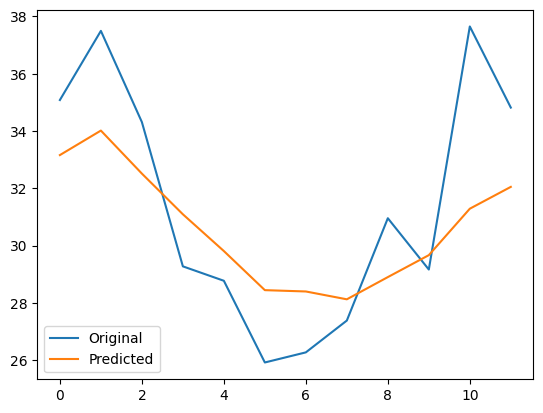

In [54]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

##### **3.5.2.	Resposta**